# **CIS 520: Machine Learning**

## **Convolutional Neural Networks**


- **Content Creators:** Edward Li
- **Content Reviewers:**  Jasleen Dhanoa, HyungSeok Roh
- **Objectives:**
    * How to build a convolutional neural net in PyTorch
    * Understand window size, stride, padding for convolutional layer
    * Understand dropout layer and how it could avoid overfitting

- **Acknowledges:**
    * Towards data science: https://towardsdatascience.com/mnist-handwritten-digits-classification-using-a-convolutional-neural-network-cnn-af5fafbc35e9
    * Neuromatch Academy
    * Graphs from  https://d2l.ai/ 



## **Autograding and the PennGrader**

First, you'll need to set up the PennGrader, which we'll be using throughout the semester to help you with your homeworks and worksheeets.

PennGrader is not only **awesome**, but it was built by an equally awesome person: Leo Murri.  Today, Leo works as a data scientist at Amazon!

PennGrader was developed to provide students with *instant* feedback on their answer. You can submit your answer and know whether it's right or wrong instantly. We then record your most recent answer in our backend database.

### Imports and Setup (Do Not Modify This Section)

In [1]:
%%capture
!pip install penngrader


In [2]:
import random 
import numpy as np
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
from numpy.linalg import *
np.random.seed(42)  # don't change this line

import dill
import base64

In [3]:
# For autograder only, do not modify this cell. 
# True for Google Colab, False for autograder
NOTEBOOK = (os.getenv('IS_AUTOGRADER') is None)
if NOTEBOOK:
    print("[INFO, OK] Google Colab.")
else:
    print("[INFO, OK] Autograder.")
    sys.exit()

[INFO, OK] Google Colab.


### Insert PennID here!

In [4]:
#PLEASE ENSURE YOUR PENN-ID IS ENTERED CORRECTLY. IF NOT, THE AUTOGRADER WON'T KNOW WHO 
#TO ASSIGN POINTS TO YOU IN OUR BACKEND
STUDENT_ID = 57931095 # YOUR PENN-ID GOES HERE AS AN INTEGER#

In [5]:
import penngrader.grader

grader = penngrader.grader.PennGrader(homework_id = 'CIS_5200_202230_HW_CNN_WS', student_id = STUDENT_ID)

PennGrader initialized with Student ID: 57931095

Make sure this correct or we will not be able to store your grade


In [6]:
# A helper function for grading utils
def grader_serialize(obj):        # A helper function
    '''Dill serializes Python object into a UTF-8 string'''
    byte_serialized = dill.dumps(obj, recurse = True)
    return base64.b64encode(byte_serialized).decode("utf-8")

## **Data Preparation**

In [7]:
import os
import numpy as np
import torch
import torchvision
from torchvision import transforms, datasets
from torch import nn, optim
from matplotlib import pyplot as plt

### Loading the data

In [8]:
!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
!tar -zxvf MNIST.tar.gz

from torchvision.datasets import MNIST
from torchvision import transforms

trainset = MNIST('./', download=True,
transform=transforms.Compose([
transforms.ToTensor(),
]), train=True)


testset = MNIST('./', download=True,
transform=transforms.Compose([
transforms.ToTensor(),
]), train=False)

# trainset = datasets.MNIST(root='./data', download=True, train=True, transform=transforms.Compose([transforms.ToTensor()]))
# testset = datasets.MNIST(root='./data', download=True, train=False, transform=transforms.Compose([transforms.ToTensor()]))

--2022-10-22 17:48:55--  http://www.di.ens.fr/~lelarge/MNIST.tar.gz
Resolving www.di.ens.fr (www.di.ens.fr)... 129.199.99.14
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.di.ens.fr/~lelarge/MNIST.tar.gz [following]
--2022-10-22 17:48:56--  https://www.di.ens.fr/~lelarge/MNIST.tar.gz
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-gzip]
Saving to: ‘MNIST.tar.gz’

MNIST.tar.gz            [                 <=>]  33.20M  8.44MB/s    in 4.1s    

2022-10-22 17:49:01 (8.06 MB/s) - ‘MNIST.tar.gz’ saved [34813078]

MNIST/
MNIST/raw/
MNIST/raw/train-labels-idx1-ubyte
MNIST/raw/t10k-labels-idx1-ubyte.gz
MNIST/raw/t10k-labels-idx1-ubyte
MNIST/raw/t10k-images-idx3-ubyte.gz
MNIST/raw/train-images-idx3-ubyte
MNIST/raw/train-labels-idx1-ubyte.gz
MNIST/raw/t10k-images-idx3-ubyte
MNIST/raw/tra

In [9]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=16, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=16, shuffle=True)

### Visualize the dataset

The label is:  tensor(2)
The label is:  tensor(3)
The label is:  tensor(7)


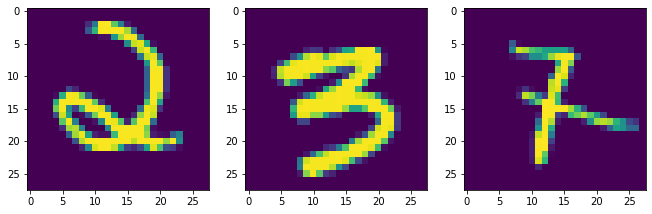

In [10]:
images, labels = iter(trainloader).next()
fig=plt.figure(figsize=(15, 10))
for i in range(1, 4):
    fig.add_subplot(1, 4, i)
    plt.imshow(images[i].numpy().squeeze())
    print('The label is: ', labels[i])
plt.show()

Remember the dimension of the image is 28 * 28, which will be very useful in designing the convolutional layer.

In [11]:
print(images.shape)

torch.Size([16, 1, 28, 28])


## Convolutional Neural Networks (CNN)

The goal is to build a model that successfully classifies hand-written digits. 

The CNN model takes an image as input and outputs what number is this hand-written digit. To do this, we will use a **convolutional neural network (CNN)**, which is a particular kind of neural network commonly used for computer vision. CNNs are just like the normal feed-forward networks from the Neural Network Worksheet, except that they have some extra layers like convolutional layers, max-pooling layer, and so on.

Now, we'll walk through the different types of layers typically present in a CNN.

## Key Component: Fully connected layers

In a fully connected layer, each unit computes a weighted sum over all the input units and applies a non-linear function to this weighted sum. You have used such layers many times already in the previous worksheet. As you have already seen, these are implemented in PyTorch using the `nn.Linear` class. Usually, you will use the fully connected layers at the end of the model pipeline. The following is similar to the one you have seen from the Neural Network Worksheet.

In [12]:
class CNN1(nn.Module):
  def __init__(self, input, hiddensize = 100):
    super().__init__()  # needed to invoke the properties of the parent class nn.Module
    self.in_layer = nn.Linear(input, hiddensize)
    self.out_layer = nn.Linear(hiddensize, 10)
    self.relu = nn.ReLU()

  def forward(self, x):
    x = self.relu(self.in_layer(x))
    x = self.out_layer(x)
    return x

## Key Component: Convolutional layers

In a convolutional layer, each unit computes a weighted sum over a two-dimensional $K \times K$ patch of inputs. The units are arranged in **channels** (see figure below), whereby units in the same channel compute the same weighted sum over different parts of the input, using the weights of that channel's **convolutional filter (or kernel)**. The output of a convolutional layer is thus a three-dimensional tensor of shape $C^{out} \times H \times W$, where $C^{out}$ is the number of channels (i.e. the number of convolutional filters/kernels), and $H$ and $W$ are the height and width of the input.

  <p align="center">
    <img src="https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/tutorials/static/convnet.png" width="350" />
  </p>

Such layers can be implemented in Python using the PyTorch class `nn.Conv2d`, which takes the same arguments as `nn.Conv1d` (documentation [here](https://pytorch.org/docs/master/generated/torch.nn.Conv2d.html)).
  




### Padding
Padding: adding extra pixels of filler around the boundary of our input image, thus increasing the effective size of the image. Typically, we set the values of the extra pixels to zero. In the following figure, we pad a  3×3  input, increasing its size to  5×5 . The corresponding output then increases to a  4×4  matrix. The shaded portions are the first output element as well as the input and kernel tensor elements used for the output computation:  0×0+0×1+0×2+0×3=0.
<p align="center">
<img src="https://github.com/yidezhao/cis520/blob/master/padding.png?raw=true" width="600" />
<p/>

### Stride
Stride: Normally, we default to sliding one element at a time. However, sometimes, either for computational efficiency or because we wish to downsample, we move our window more than one element at a time, skipping the intermediate locations. The following figure shows a two-dimensional cross-correlation operation with a stride of 3 vertically and 2 horizontally. The shaded portions are the output elements as well as the input and kernel tensor elements used for the output computation:  0×0+0×1+1×2+2×3=8 ,  0×0+6×1+0×2+0×3=6 . We can see that when the second element of the first column is outputted, the convolution window slides down three rows. The convolution window slides two columns to the right when the second element of the first row is outputted. When the convolution window continues to slide two columns to the right on the input, there is no output because the input element cannot fill the window (unless we add another column of padding).
<p align="center">
<img src="https://github.com/yidezhao/cis520/blob/master/stride.png?raw=true" width="600" />
<p/>

## Example 1: One convolutional layer CNN
The following is an example of a one convolutional layer CNN. For the convolutional layer, the kernal size is 3*3, the stride is 1 and padding is 1.

In [13]:
class CNN2(torch.nn.Module):
    def __init__(self):
        super(CNN2, self).__init__()
        self.conv_1 = torch.nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.linear_1 = torch.nn.Linear(28 * 28 * 16, 128)
        self.linear_2 = torch.nn.Linear(128, 10)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv_1(x))
        x = x.reshape(x.size(0), -1) # Flatten the image from [16, 16, 28, 28] to [16, 16*28*28] 
        x = self.relu(self.linear_1(x))
        x = self.linear_2(x)
        return x

## *Question 1*
1. Implement a CNN in the following code snippet. The CNN has 2 convolutional layers. The first layer has 1 in_channels, 32 out_channels, kernel size 3, 1 stride and 1 padding. The second layer has 32 in_channels, 64 out_channels. Choose the same kernel size, stride, and padding. 
*HINT: make sure your dimensions fit and flatten the image before passing into dense layer.*

*HINT: Please refer to [this link](https://towardsdatascience.com/mnist-handwritten-digits-classification-using-a-convolutional-neural-network-cnn-af5fafbc35e9) for additional guidance on linear layer dimensionalities if needed.*

In [42]:
# Please implement this class. The first layer has already been completed for you.

class CNN3(torch.nn.Module):
    def __init__(self):
        super(CNN3, self).__init__()
        self.conv_1 = torch.nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv_2 = torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.linear_1 = torch.nn.Linear(28*28*64, 128)
        self.linear_2 = torch.nn.Linear(128, 10)
        self.relu = torch.nn.ReLU()
    def forward(self, x):
        x = self.relu(self.conv_1(x))
        x = self.relu(self.conv_2(x))
        x = self.reshape(x.size(0), -1)
        x = self.relu(self.linear_1(x))
        x = self.relu(self.linear_2(x))
        return x

In [15]:
# Copy and paste your above layer definitions over. Make sure there are NO multiplication signs ("*").

cnn3_conv_1 = "torch.nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)"
cnn3_conv_2 = "torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)"
cnn3_linear_1 = "torch.nn.Linear(50176, 128)"
cnn3_linear_2 = "torch.nn.Linear(128, 10)"
cnn3_relu = "torch.nn.ReLU()"


In [16]:
grader.grade(test_case_id = 'test_case_CNN3_1', answer = cnn3_conv_2)

Correct! You earned 0.5/0.5 points. You are a star!

Your submission has been successfully recorded in the gradebook.


In [17]:
grader.grade(test_case_id = 'test_case_CNN3_2', answer = cnn3_linear_1)

Correct! You earned 0.5/0.5 points. You are a star!

Your submission has been successfully recorded in the gradebook.


In [18]:
grader.grade(test_case_id = 'test_case_CNN3_3', answer = cnn3_linear_2)

Correct! You earned 0.5/0.5 points. You are a star!

Your submission has been successfully recorded in the gradebook.


In [19]:
grader.grade(test_case_id = 'test_case_CNN3_4', answer = cnn3_relu)

Correct! You earned 0.5/0.5 points. You are a star!

Your submission has been successfully recorded in the gradebook.


## Key Component: Max pooling layers

In a max pooling layer, each unit computes the maximum over a small two-dimensional $K^{pool} \times K^{pool}$ patch of inputs. Given a multi-channel input of dimensions $C \times H \times W$, the output of a max pooling layer has dimensions $C \times H^{out} \times W^{out}$, where:
\begin{align}
  H^{out} &= \left\lfloor \frac{H}{K^{pool}} \right\rfloor\\
  W^{out} &= \left\lfloor \frac{W}{K^{pool}} \right\rfloor
\end{align}
$\lfloor\cdot\rfloor$ denotes rounding down to the nearest integer below (i.e. floor division `//` in Python).

  Max pooling layers can be implemented with the PyTorch `nn.MaxPool2d` class, which takes as a single argument the size $K^{pool}$ of the pooling patch. Note that we need to calculate the dimensions of its output in order to set the dimensions of the subsequent fully connected layer.

In [20]:
class CNN4(torch.nn.Module):
    def __init__(self):
        super(CNN4, self).__init__()
        self.conv_1 = torch.nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.max_pool2d = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.linear_1 = torch.nn.Linear(14 * 14 * 16, 128)
        self.linear_2 = torch.nn.Linear(128, 10)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv_1(x))
        x = self.max_pool2d(x)
        x = x.reshape(x.size(0), -1) 
        x = self.relu(self.linear_1(x))
        x = self.linear_2(x)
        return x

## *Question 2*
1. Implement a CNN in the following code snippet. The CNN should have 2 convolutional layers, each followed by a max pooling layer. The first layer has been already implemented for you. The second convolutional layer has 32 in_channels, 64 out_channels. Choose the same kernel size, stride, and padding. Add a max pooling layer after the second convolutional layer. 

*HINT: make sure your dimensions fit and flatten the image before passing into dense layer.*

*HINT: Please refer to [this link](https://towardsdatascience.com/mnist-handwritten-digits-classification-using-a-convolutional-neural-network-cnn-af5fafbc35e9) for additional guidance on linear layer dimensionalities if needed.*

In [43]:
class CNN5(torch.nn.Module):
    def __init__(self):
        super(CNN5, self).__init__()
        self.conv_1 = torch.nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.max_pool2d = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = torch.nn.ReLU()
        # TODO: add the second convolutional layer and dense layers. Report these layers below
        self.conv_2 = torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.linear_1 = torch.nn.Linear(28*28*4, 128)
        self.linear_2 = torch.nn.Linear(128, 10)

    def forward(self, x):
        x = self.relu(self.conv_1(x))
        x = self.max_pool2d(x)
        # TODO: Repeat with conv_2, flatten, then implement dense layers
        x = self.relu(self.conv_2(x))
        x = self.max_pool2d(x)
        x = x.reshape(x.size(0), -1)
        x = self.linear_1(x)
        x = self.linear_2(x)
        return x        

In [36]:
# Copy and paste your above answers over. Make sure there are NO multiplication signs ("*").

cnn5_conv_2 = "torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)"
cnn5_linear_1 = "torch.nn.Linear(3136, 128)"
cnn5_linear_2 = "torch.nn.Linear(128, 10)"


In [31]:
grader.grade(test_case_id = 'test_case_CNN5_1', answer = cnn5_conv_2)

Correct! You earned 0.5/0.5 points. You are a star!

Your submission has been successfully recorded in the gradebook.


In [37]:
grader.grade(test_case_id = 'test_case_CNN5_2', answer = cnn5_linear_1)

Correct! You earned 1.0/1.0 points. You are a star!

Your submission has been successfully recorded in the gradebook.


In [25]:
grader.grade(test_case_id = 'test_case_CNN5_3', answer = cnn5_linear_2)

Correct! You earned 0.5/0.5 points. You are a star!

Your submission has been successfully recorded in the gradebook.


In [44]:
# Let's test your CNN5() for one epoch.

epochs = 1
model = CNN5()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3) 
train_loss = []
# training iteration
for epoch in range(epochs):
    running_loss = 0
    for itr, (image, label) in enumerate(trainloader):
        # zero gradient
        optimizer.zero_grad()
        # forward path
        y_predicted = model(image)
        loss = criterion(y_predicted, label)
        running_loss += loss.item()
        # backpropagating
        loss.backward()
        # optimizes the weights
        optimizer.step()
    train_loss.append(running_loss)
    print(f'epoch: {epoch+1}, loss: {running_loss:.4f}')

epoch: 1, loss: 422.4227


In [45]:
# Report the loss value from the first epoch of training. Round to the nearest HUNDREDTHS place

cnn5_loss = 422.42

In [46]:
grader.grade(test_case_id = 'test_case_CNN5_loss', answer = cnn5_loss)

Correct! You earned 1.0/1.0 points. You are a star!

Your submission has been successfully recorded in the gradebook.


## Key Component: Dropout
In standard dropout regularization, one debiases each layer by normalizing by the fraction of nodes that were retained (not dropped out). In other words, with dropout probability  𝑝 , each intermediate activation  ℎ  is replaced by a random variable  ℎ′  as follows:
\begin{equation}
h^{\prime}=\left\{\begin{array}{ll}
0 & \text { with probability } p \\
\frac{h}{1-p} & \text { otherwise }
\end{array}\right.
\end{equation}
By design, the expectation remains unchanged, i.e.,  𝐸[ℎ′]=ℎ .


When we apply dropout to a hidden layer, zeroing out each hidden unit with probability  𝑝 , the result can be viewed as a network containing only a subset of the original neurons. In the following figure,  ℎ2  and  ℎ5  are removed. Consequently, the calculation of the outputs no longer depends on  ℎ2  or  ℎ5  and their respective gradient also vanishes when performing backpropagation. In this way, the calculation of the output layer cannot be overly dependent on any one element of  ℎ1, … ,ℎ5.
<p align="center">
<img src="https://github.com/yidezhao/cis520/blob/master/dropout.png?raw=ture" width="600" />
<p/>

In [47]:
class CNN6(torch.nn.Module):
    def __init__(self):
        super(CNN6, self).__init__()
        self.conv_1 = torch.nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.max_pool2d = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.linear_1 = torch.nn.Linear(14 * 14 * 32, 128)
        self.linear_2 = torch.nn.Linear(128, 10)
        self.dropout = torch.nn.Dropout(p=0.5)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv_1(x))
        x = self.max_pool2d(x)
        x = x.reshape(x.size(0), -1)
        x = self.relu(self.linear_1(x))
        x = self.dropout(x)
        x = self.linear_2(x)
        return x

In [48]:
epochs = 10
model = CNN6()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3) 
train_loss = []
# training iteration
for epoch in range(epochs):
    running_loss = 0
    for itr, (image, label) in enumerate(trainloader):
        # zero gradient
        optimizer.zero_grad()
        # forward path
        y_predicted = model(image)
        loss = criterion(y_predicted, label)
        running_loss += loss.item()
        # backpropagating
        loss.backward()
        # optimizes the weights
        optimizer.step()
    train_loss.append(running_loss)
    if (epoch+1) % 2 == 0:
        print(f'epoch: {epoch+1}, loss: {running_loss:.4f}')

epoch: 2, loss: 553.2142
epoch: 4, loss: 344.0649
epoch: 6, loss: 259.1949
epoch: 8, loss: 203.9825
epoch: 10, loss: 181.2023


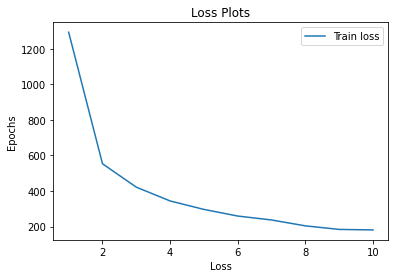

In [49]:
fig=plt.figure()
plt.plot(np.arange(1, epochs+1), train_loss, label="Train loss")
plt.xlabel('Loss')
plt.ylabel('Epochs')
plt.title("Loss Plots")
plt.legend(loc='upper right')
plt.show()

Now, test the accuracy of the model on the test set.

In [50]:
correct = 0
total = 0
with torch.no_grad():
    for itr, (image, label) in enumerate(testloader):
        outputs = model(image)
        _, predicted = torch.max(outputs.data, 1)
        correct += predicted.eq(label.reshape(len(label),)).sum() 
        total += float(len(label))
    accuracy = correct / total
    print(f'Accuracy of Neural Network is {accuracy:.4f}')

Accuracy of Neural Network is 0.9781


## *Question 3*
1. Add a dropout layer (p=0.5) to your CNN5 from exercise in the following code snippet. You do not need to change the structure.
2. Train your final model
3. Draw out the loss

In [56]:
class CNN7(torch.nn.Module):
    def __init__(self):
        super(CNN7, self).__init__()
        self.conv_1 = torch.nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.max_pool2d = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = torch.nn.ReLU()
        # TODO: add the second convolutional layer, dense layers, and dropout layer
        self.conv_2 = torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.linear_1 = torch.nn.Linear(7*7*64, 128)
        self.linear_2 = torch.nn.Linear(128, 10)
        self.dropout = torch.nn.Dropout(p=0.5)

    def forward(self, x):
        x = self.relu(self.conv_1(x))
        x = self.max_pool2d(x)
        # TODO: Repeat with conv_2, flatten, then implement dense layers. Don't forget dropout!
        x = self.relu(self.conv_2(x))
        x = self.max_pool2d(x)
        x = x.reshape(x.size(0), -1)
        x = self.relu(self.linear_1(x))
        x = self.dropout(x)
        x = self.linear_2(x)
        return x


In [57]:
# TODO 3.2
epochs = 10
model = CNN7()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3) 
train_loss = []
# training iteration
for epoch in range(epochs):
    running_loss = 0
    for itr, (image, label) in enumerate(trainloader):
        # TODO: Implement the training here. Use CNN6() as reference.
        # zero gradient
        optimizer.zero_grad()
        # forward path
        y_predicted = model(image)
        loss = criterion(y_predicted, label)
        running_loss += loss.item()
        # backpropagating
        loss.backward()
        # optimizes the weights
        optimizer.step()

    train_loss.append(running_loss)
    print(f'epoch: {epoch+1}, loss: {running_loss:.4f}')

epoch: 1, loss: 895.3804
epoch: 2, loss: 372.6409
epoch: 3, loss: 281.4049
epoch: 4, loss: 232.6099
epoch: 5, loss: 198.5967
epoch: 6, loss: 170.1840
epoch: 7, loss: 143.7881
epoch: 8, loss: 135.4523
epoch: 9, loss: 119.6077
epoch: 10, loss: 106.8367


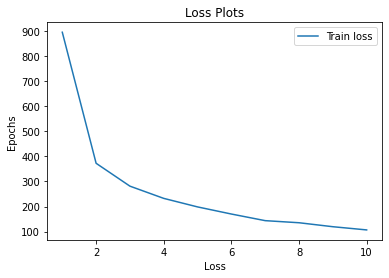

In [58]:
# Plot the training loss

fig=plt.figure()
plt.plot(np.arange(1, epochs+1), train_loss, label="Train loss")
plt.xlabel('Loss')
plt.ylabel('Epochs')
plt.title("Loss Plots")
plt.legend(loc='upper right')
plt.show()

In [59]:
grader.grade(test_case_id = 'test_case_CNN7_loss', answer = train_loss)

You earned 0.0/3.0 points.

But, don't worry you can re-submit and we will keep only your latest score.


In [60]:
# Find the accuracy of the model on the test set.

correct = 0
total = 0
with torch.no_grad():
    for itr, (image, label) in enumerate(testloader):
        # TODO: Implement the testing here. Use CNN6() as reference.
        outputs = model(image)
        _, predicted = torch.max(outputs.data, 1)
        correct += predicted.eq(label.reshape(len(label),)).sum() 
        total += float(len(label))
    accuracy = correct / total
    print(f'Accuracy of Neural Network is {accuracy:.4f}')

Accuracy of Neural Network is 0.9857


In [63]:
# Report the accuracy to the nearest HUNDREDTHS place

cnn7_acc = 0.98

In [64]:
grader.grade(test_case_id = 'test_case_CNN7_acc', answer = cnn7_acc)

Correct! You earned 2.0/2.0 points. You are a star!

Your submission has been successfully recorded in the gradebook.


## Submitting to the Autograder

First of all, please run your notebook from beginning to end and ensure you are getting all the points from the autograder!

Now go to the File menu and choose "Download .ipynb".  Go to [Gradescope](https://www.gradescope.com/courses/409970) and:

1. From "File" --> Download both .ipynb and .py files
1. Name these files `CNN_WS.ipynb` and `CNN_WS.py` respectively
1. Sign in using your Penn email address (if you are a SEAS student we recommend using the Google login) and ensure  your class is "CIS 5200"
1. Select **Worksheet: CNN**
1. Upload both files
1. PLEASE CHECK THE AUTOGRADER OUTPUT TO ENSURE YOUR SUBMISSION IS PROCESSED CORRECTLY!

You should be set! Note that this assignment has 10 autograded points that will show up upon submission. Points are awarded based on a combination of correctness and sufficient effort. 